In [55]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import json

In [49]:
path = 'minimal_pkls/'
save_path = 'processed_jsons/'
os.makedirs(save_path, exist_ok=True)
files = os.listdir(path)
len(files)

55

In [58]:
from social_phi import get_signal,experiment_hop_range

def flatten(l : list):
    return [item for sublist in l for item in sublist]

def extract_data(file, time_scale=24*3600, window=30):
    if os.path.exists(save_path + file[:-4] + '.json'):
        return
    
    data = pickle.load(open(path + file, 'rb'))
    act = flatten(data['activities'].values())
    sig = get_signal(data['activities'], time_scale=time_scale, binarize=True)
    stats = experiment_hop_range(sig=sig, window=window, min_hop=1, max_hop=window, silent=True)
    
    res = {
        'forks' : data['forks'],
        'issues' : data['issues'],
        'stars' : data['stars'],
        'users' : len(data['activities']),
        'commits' : len(act),
        'avg_phi' : max(stats['avg_phi']),
        'timeline' : (max(act) - min(act)) // time_scale
    }
    json.dump(res, open(save_path + file[:-4] + '.json', 'w'))

In [ ]:
for file in tqdm(files):
    print(file)
    extract_data(file)

30-seconds-30-seconds-of-code.pkl
nuxt-nuxt.js.pkl
webpack-webpack.pkl
apache-superset.pkl


In [8]:
df = pd.DataFrame(columns=['forks', 'stars', 'issues', 'users', 'commits', 'timeline', 'avg_phi'])
for file in os.listdir('processed_jsons/'):
    rec = json.load(open('processed_jsons/' + file))
    df = df.append(rec, ignore_index=True)
df = df.astype(float)
df.describe()

,forks,stars,issues,users,commits,avg_phi,timeline
count,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000
mean,6878.600000,26544.000000,1402.000000,775.266667,16563.266667,1.109419,3203.133333
std,5477.440041,11236.736848,1668.490378,681.635058,14564.091485,0.250737,1601.532697
min,1378.000000,5530.000000,12.000000,75.000000,1342.000000,0.840441,1278.000000
25%,3845.500000,16861.000000,402.500000,262.000000,4436.000000,0.895846,2114.000000
50%,5518.000000,30083.000000,907.000000,495.000000,11882.000000,1.097988,2768.000000
75%,7821.000000,37120.000000,1592.500000,1268.500000,25185.000000,1.244811,4219.500000
max,23094.000000,39900.000000,6313.000000,2322.000000,52223.000000,1.589701,7122.000000


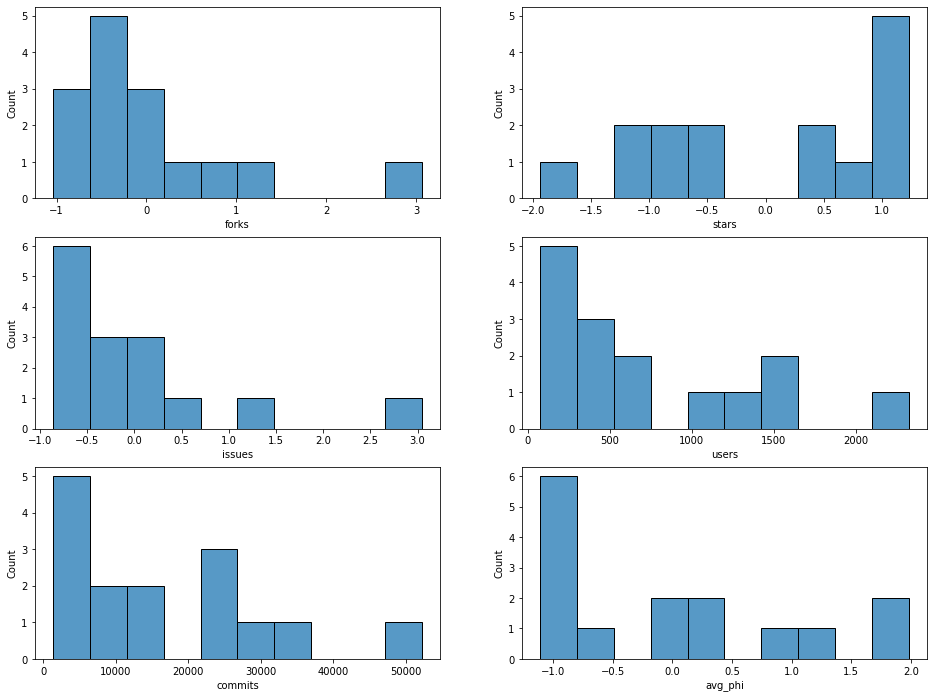

In [34]:
plt.figure(figsize=(16,12))

plt.subplot(3,2,1)
sns.histplot(df['forks'], bins=10)

plt.subplot(3,2,2)
sns.histplot(df['stars'], bins=10)

plt.subplot(3,2,3)
sns.histplot(df['issues'], bins=10)

plt.subplot(3,2,4)
sns.histplot(df['users'], bins=10)

plt.subplot(3,2,5)
sns.histplot(df['commits'], bins=10)

plt.subplot(3,2,6)
sns.histplot(df['avg_phi'], bins=10)

plt.show()

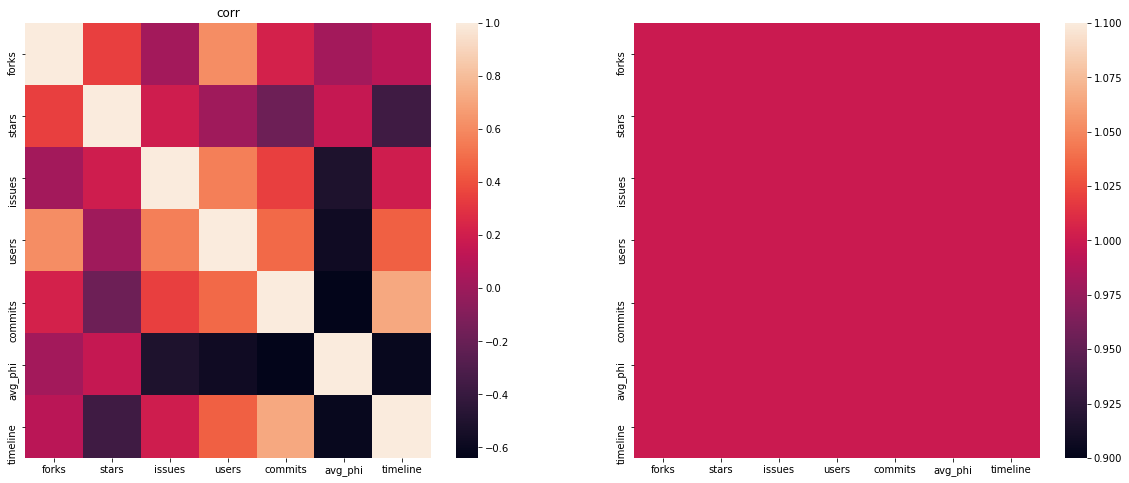

In [42]:
from sklearn.metrics import mutual_info_score, normalized_mutual_info_score, adjusted_mutual_info_score

plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.title('corr')
sns.heatmap(df.corr())

mis = np.zeros(shape=(df.shape[1], df.shape[1]))
for i in range(df.shape[1]):
    for j in range(df.shape[1]):
        mis[i,j] = adjusted_mutual_info_score(df[df.columns[i]], df[df.columns[j]])

plt.subplot(1,2,2)
sns.heatmap(pd.DataFrame(mis, columns=df.columns, index=df.columns))
plt.show()

In [43]:
# from social_phi import get_single_signal

# def display_growth(col):
#     for data in all_data:
#         sig, _, _ = get_single_signal(data[col], time_scale=24*3600, binarize=False)
#         cum_sig = [sig[:i+1].sum() for i in range(len(sig))]
#         plt.plot(cum_sig)
        
# def display_commit_growth():
#     for data in all_data:
#         act = flatten(data['activities'].values())
#         sig, _, _ = get_single_signal(act, time_scale=24*3600, binarize=False)
#         cum_sig = [sig[:i+1].sum() for i in range(len(sig))]
#         plt.plot(cum_sig)

# plt.figure(figsize=(16,16))

# plt.subplot(4,1,1)
# plt.title('forks')
# display_growth('forks')

# plt.subplot(4,1,2)
# plt.title('stars')
# display_growth('stars')

# plt.subplot(4,1,3)
# plt.title('issues')
# display_growth('issues')

# plt.subplot(4,1,4)
# plt.title('commits')
# display_commit_growth()
    
# plt.show()